## Section 5.0

We created a gradient boosted decision tree with Python XGboost to predict whether the transactions not meeting our rule based critiera were fraudulent or not. When tested on a holdout set, we found that our model produced a perfect AUC.

In [183]:
#hour.drop(['nameOrig', 'nameDest'], axis = 1, inplace = True)
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import pickle
%matplotlib inline
plt.style.use('ggplot')

gc.collect()


dtypes = {
    
    'Unnamed'         :    'uint32',
    'step'            :    'uint8',    
    'amount'          :    'float32',
    'oldbalanceOrg'   :    'float32',
    'newbalanceOrig'  :    'float32',
    'oldbalanceDest'  :    'float32',
    'newbalanceDest'  :    'float32',
    'isFraud'         :    'uint8',
    'isFlaggedFraud'  :    'uint8',
    'day'             :    'uint8',
    'hour'            :    'uint8',
    'transfer'        :    'uint8',
    'cashOut'         :    'uint8',
    'origC'           :    'uint8',
    'destC'           :    'uint8',
    'detect'          :    'uint8',
    'AMNB0'           :    'float32',
    'AMOBO'           :    'float32',
    'AMNBD'           :    'float32',
    'AMOBD'           :    'float32',
    'NOBRD'           :    'float32'

}


train = pd.read_csv('train2.csv', dtype = dtypes, index_col = 0)

C:\Users\andrewmauro\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [184]:
#split data into training and holdout
#holdout - last 10 days
#train - first 20 days
holdout = train[(train['day'] > 19)]
train = train[(train['day'] <= 19)]
y_true = holdout['isFraud']

rbHold = holdout[holdout['detect'] == 1]
holdout = holdout[holdout['detect'] != 1]
train = train[train['detect'] == 1]

train.drop('detect', axis = 1, inplace = True)
holdout.drop(['detect', 'isFraud'], axis = 1, inplace = True)

#print(train.shape, train['isFraud'].mean() * 100,
#print(train.shape, train['isFraud'].mean() * 100, holdout.shape,  holdout['isFraud'].mean() * 100)

In [185]:
params = {'eta': 0.1, 
          'max_depth': 2, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':1,
          'alpha':4,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 99, 
          'silent': True}
          
x1 = train[train['day'] <= 14]
x1.drop(['isFraud'], axis=1, inplace=True)
y1 = train[train['day'] <= 14]
y1 = y1['isFraud']

x2 = train[train['day'] > 14]
x2.drop(['isFraud'], axis=1, inplace=True)
y2 = train[train['day'] > 14]
y2 = y2['isFraud']

trainSplit = xgb.DMatrix(x1, y1)
testSplit = xgb.DMatrix(x2, y2)

start_time = time.time()
start_time = time.time()
print('[{}] Start XGBoost Training'.format(time.time() - start_time))

#del train
gc.collect()

watchlist = [(trainSplit, 'train'), (testSplit, 'valid')]
model = xgb.train(params, trainSplit, 200, watchlist, maximize=True, verbose_eval=10, early_stopping_rounds = 20)

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

preds = model.predict(xgb.DMatrix(holdout), ntree_limit=model.best_ntree_limit)

print('[{}] Finish XGBoost Predict'.format(time.time() - start_time))

[0.0] Start XGBoost Training
[0]	train-auc:0.980682	valid-auc:1
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.


C:\Users\andrewmauro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\andrewmauro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[10]	train-auc:0.999879	valid-auc:1
[20]	train-auc:0.999956	valid-auc:1
Stopping. Best iteration:
[0]	train-auc:0.980682	valid-auc:1

[0.19376134872436523] Finish XGBoost Training
[0.4553992748260498] Finish XGBoost Predict


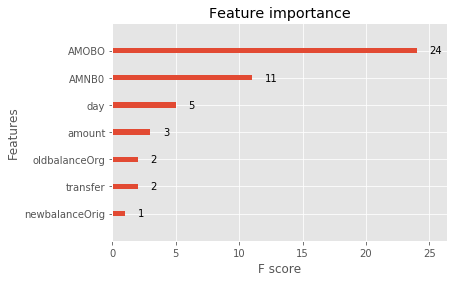

In [186]:
%matplotlib inline
xgb.plot_importance(model)

In [187]:
#store all information in holdout
holdout['model'] = np.where(preds > .55, 1, 0)
holdout = holdout.append(rbHold)
holdout['isFraud'] = y_true
holdout['pred'] = np.where(holdout['detect'] == 1, 1, holdout['model'])
del y_true
gc.collect()

32

In [188]:
roc_auc_score(y_true = holdout['isFraud'], y_score = holdout['pred'])

1.0

In [189]:
#No false negatives
holdout[(holdout['isFraud'] == 1) & (holdout['pred'] != 1)]

,AMNB0,AMNBD,AMOBD,AMOBO,NOBRD,amount,cashOut,day,destC,detect,...,isFraud,model,newbalanceDest,newbalanceOrig,oldbalanceDest,oldbalanceOrg,origC,step,transfer,pred


In [191]:
#No False Positives
holdout[(holdout['isFraud'] == 0) & (holdout['pred'] == 1)]

,AMNB0,AMNBD,AMOBD,AMOBO,NOBRD,amount,cashOut,day,destC,detect,...,isFraud,model,newbalanceDest,newbalanceOrig,oldbalanceDest,oldbalanceOrg,origC,step,transfer,pred
